<a href="https://colab.research.google.com/github/miftakhlaziz/Flowers_Classification_Using_CNN/blob/master/Flower_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
# data visualization and manipulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

# preprocess.
from keras.preprocessing.image import ImageDataGenerator

#deep learning libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for convolutional neural networks
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import tensorflow_hub as hub
import random as rn

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)
print("GPU", "available (True)" if tf.config.list_physical_devices("GPU") else "not available :(")

Using TensorFlow backend.


TF version: 2.2.0-rc3
TF Hub version: 0.8.0
GPU available (True)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/"
daisy_flower_dir = root_dir + "/Colab Notebooks/Flower Classification Using CNN/flowers_dataset/daisy"
sunflower_dir = root_dir + "/Colab Notebooks/Flower Classification Using CNN/flowers_dataset/sunflower"
tulip_flower_dir = root_dir + "/Colab Notebooks/Flower Classification Using CNN/flowers_dataset/tulip"
dandelion_flower_dir = root_dir + "/Colab Notebooks/Flower Classification Using CNN/flowers_dataset/dandelion"
rose_flower_dir = root_dir + "/Colab Notebooks/Flower Classification Using CNN/flowers_dataset/rose"

In [0]:
Img_Array = []
Img_Label = []

def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        
        Img_Array.append(np.array(img))
        Img_Label.append(str(label))

In [5]:
make_train_data('Daisy',daisy_flower_dir)
make_train_data('Sunflower',sunflower_dir)
make_train_data('Tulip',tulip_flower_dir)
make_train_data('Dandelion',dandelion_flower_dir)
make_train_data('Rose',rose_flower_dir)

100%|██████████| 784/784 [00:03<00:00, 213.82it/s]


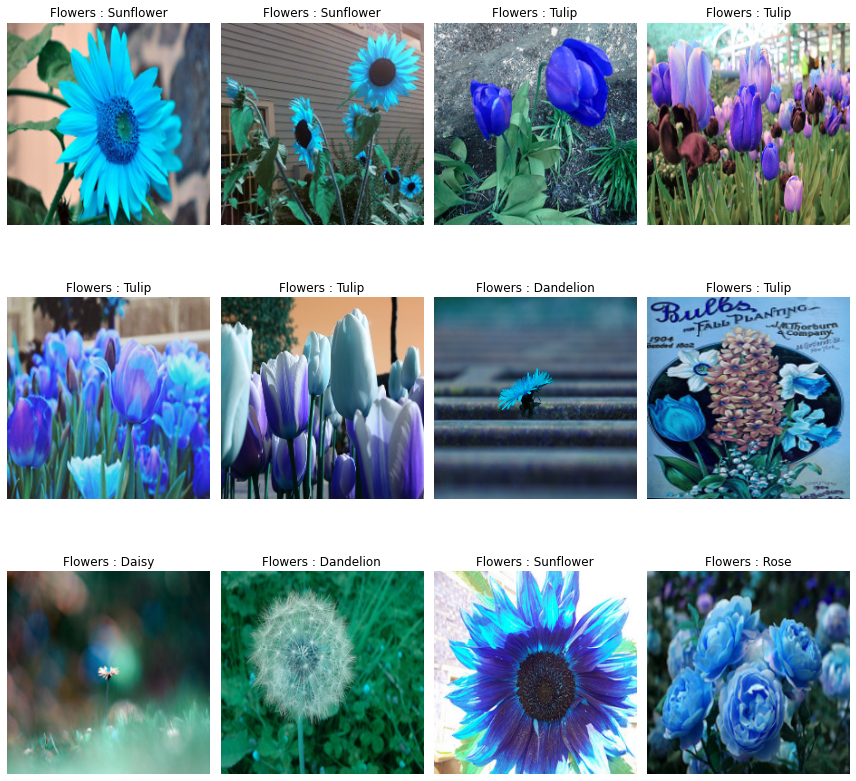

In [6]:
# Check visualization random images
fig,ax=plt.subplots(3,4)
fig.set_size_inches(12,12)
for i in range(3):
    for j in range (4):
        l=rn.randint(0,len(Img_Label))
        ax[i,j].axis('off')
        ax[i,j].imshow(Img_Array[l])
        ax[i,j].set_title('Flowers : '+Img_Label[l])

plt.tight_layout()
plt.show()

In [0]:
# label
le=LabelEncoder()
Y=le.fit_transform(Img_Label)
Y=to_categorical(Y,5)
X=np.array(Img_Array)
X=X/255

# setting random seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# split train and validation sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [0]:
batch_size=128
epochs=100
lr = 0.001

datagen = ImageDataGenerator(
          featurewise_center=False,
          samplewise_center=False,
          featurewise_std_normalization=False,
          samplewise_std_normalization=False,
          zca_whitening=False,
          rotation_range=10,
          zoom_range = 0.1,
          width_shift_range=0.2,
          height_shift_range=0.2,
          horizontal_flip=True,
          vertical_flip=False)

datagen.fit(x_train)

In [0]:
# modelling CNN.
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (6,6),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters =64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [10]:
model.compile(optimizer=Adam(lr),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1744      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)      

In [11]:
History = model.fit(datagen.flow (x_train,y_train, batch_size=batch_size),
          epochs = epochs, validation_data = (x_test,y_test),
          verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/100
27/27 [==============================] - 32s 1s/step - loss: 1.6229 - accuracy: 0.2508 - val_loss: 1.5713 - val_accuracy: 0.2460
Epoch 2/100
27/27 [==============================] - 31s 1s/step - loss: 1.4183 - accuracy: 0.4001 - val_loss: 1.2849 - val_accuracy: 0.4874
Epoch 3/100
27/27 [==============================] - 31s 1s/step - loss: 1.2413 - accuracy: 0.4810 - val_loss: 1.0989 - val_accuracy: 0.5529
Epoch 4/100
27/27 [==============================] - 31s 1s/step - loss: 1.0622 - accuracy: 0.5832 - val_loss: 1.1328 - val_accuracy: 0.5483
Epoch 5/100
27/27 [==============================] - 31s 1s/step - loss: 1.0413 - accuracy: 0.5823 - val_loss: 0.9934 - val_accuracy: 0.5897
Epoch 6/100
27/27 [==============================] - 31s 1s/step - loss: 0.9501 - accuracy: 0.6220 - val_loss: 0.9133 - val_accuracy: 0.6264
Epoch 7/100
27/27 [==============================] - 32s 1s/step - loss: 0.9394 - accuracy: 0.6253 - val_loss: 0.8693 - val_accuracy: 0.6552
Epoch 8/100
2

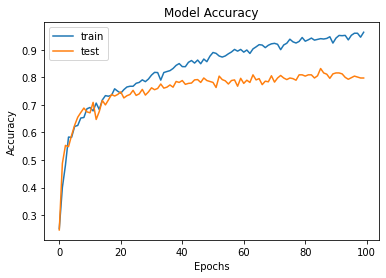

In [20]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

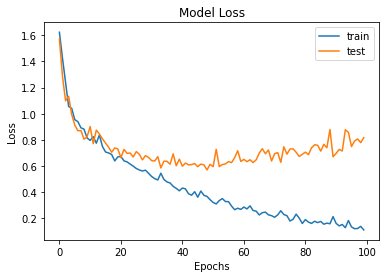

In [21]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Visualization from predictions class

In [0]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
# init visualizations
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==40):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==40):
        break

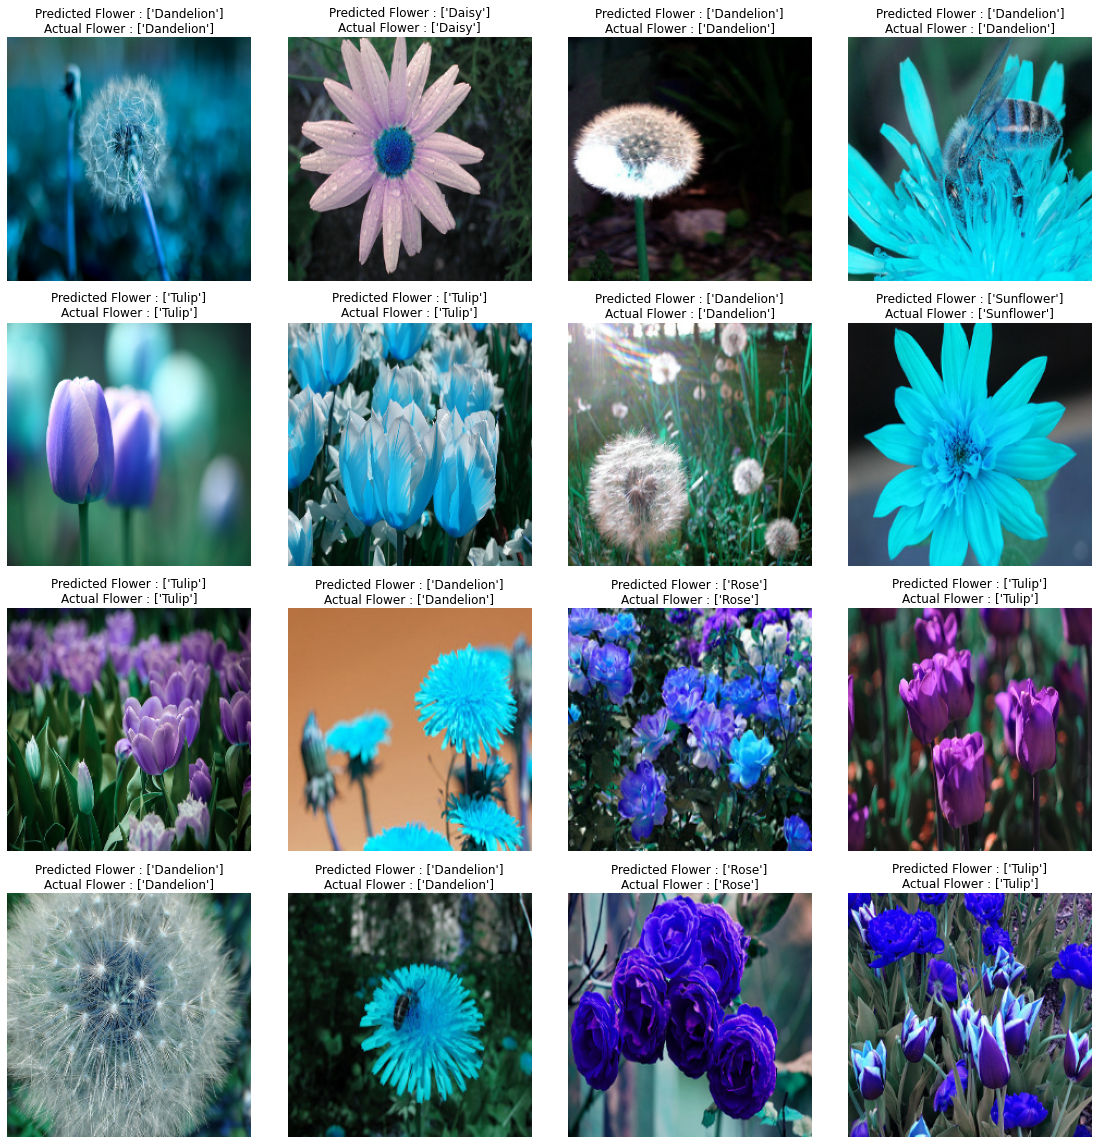

In [43]:
# True Predictions
count=0
fig,ax=plt.subplots(4,4)
fig.set_size_inches(16,16)
for i in range (4):
    for j in range (4):
        ax[i,j].axis('off')
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+
                          "Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

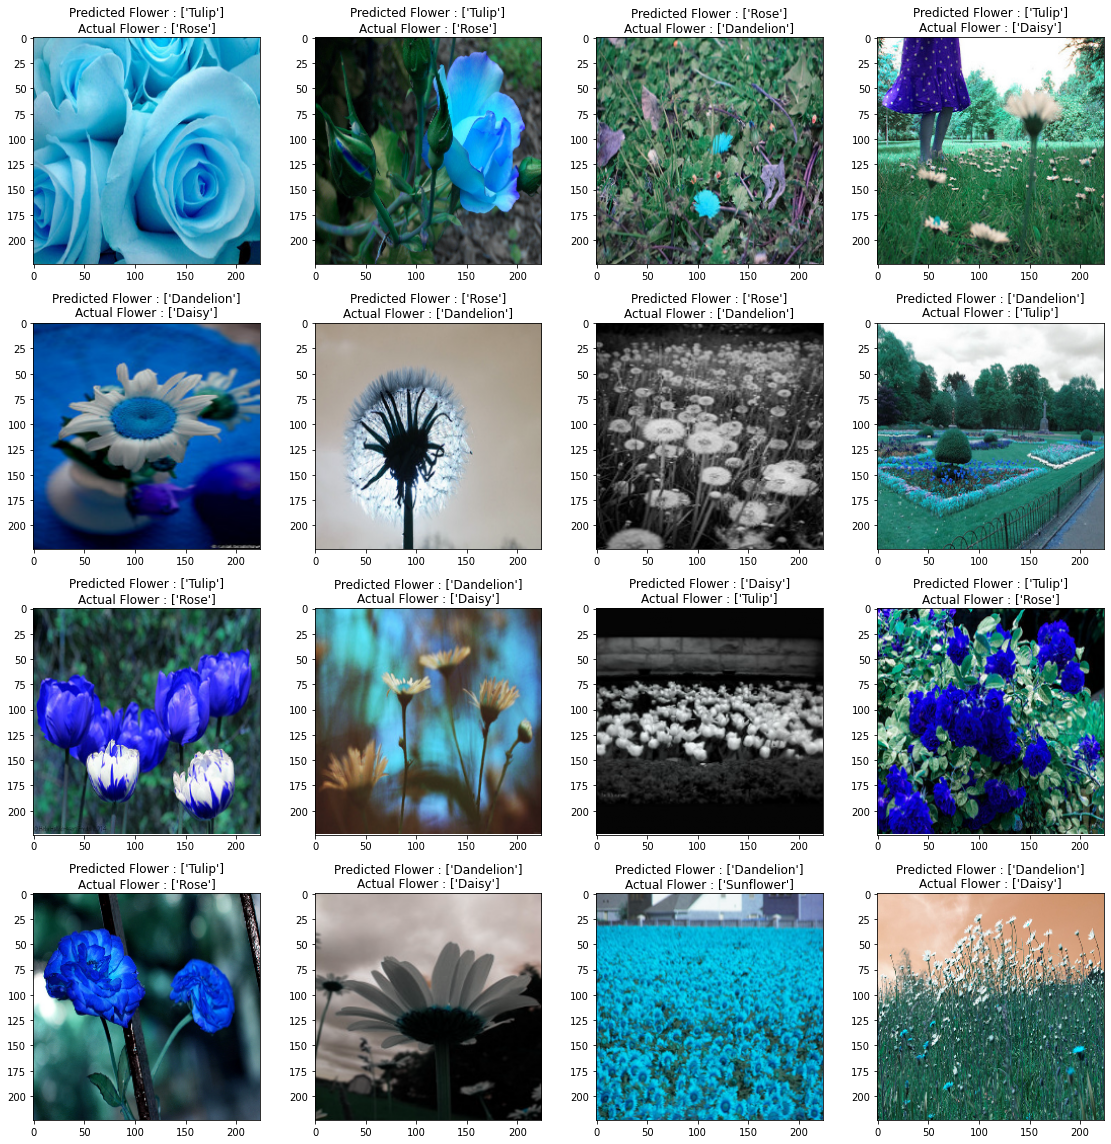

In [44]:
# False Predictions
count=0
fig,ax=plt.subplots(4,4)
fig.set_size_inches(16,16)
for i in range (4):
    for j in range (4):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+
                          "Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1